***DATA ANALYSIS***

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os #file I/O
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import os

%matplotlib inline

import matplotlib.pyplot as plt #used for plotting and analyzing data

#used for image display
import PIL 
from PIL import Image

# tensorflow
import tensorflow as tf
from tensorflow import keras
print(keras)
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.python.keras.models import Sequential
from keras import layers

import matplotlib.pyplot as plt
from sklearn.metrics import auc,roc_curve
import seaborn as sns
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import PIL 
from PIL import Image

<module 'keras.api._v2.keras' from 'd:\\Programy\\Anaconda\\lib\\site-packages\\keras\\api\\_v2\\keras\\__init__.py'>


Porozumění datům:
Melanoma - typ rakoviny kůže
Melanocytic nevus - piha
Basal cell carcinoma - typ rakoviny kůže
Actinic keratosis - poškození kůže z dlouhodobého vystavení UV paprskům, v 5-10% může z tohoto typu poškození vzniknout rakovina kůže
Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis) - neškodná, tmavě zbarvená ploška na kůži
Dermatofibroma - maké neškodné výrůstky na kůži
Vascular lesion - mateřské znaménko
Squamous cell carcinoma - typ rakoviny kůže
None of the above`

Chceme-li v naší práci klasifikovat pouze znaménka s podezřením na rakovinu kůže a znaménka bez podezření na rakovinu kůže, je nutné spojit výše uvedené pouze do dvou ktegorií:
- riziko rakoviny: 
    - MEL Melanoma
    - BCC Basal cell carcinoma
    - AK Actinic keratosis (vzhledem k pravděpodobnosti, že z toho typu poškození kůže se rakovina vyvine, přijde nám vhodné zařadit tuto kategoii do kategorie rizikové, abychom snížili pravděpodobnost falešně negativnívh výsledků)
    - SCC Squamous cell carcinoma
- nerizikové znaménko:
    - NV Melanocytic nevus
    - BKL Benign keratosis
    - DF Dermatofibroma
    - VASC Vascular lesion
- pro kategorii "none of the above" nemáme k dispozici data

In [2]:
import os
print(os.listdir("data"))

['ISIC_2019_Training_GroundTruth.csv', 'ISIC_2019_Training_Metadata.csv', 'Skin cancer ISIC The International Skin Imaging Collaboration']


In [3]:
path='data'
csv_file='data\ISIC_2019_Training_GroundTruth.csv'

In [4]:
data = pd.read_csv("data\ISIC_2019_Training_GroundTruth.csv", header = 0)
data.head(20)

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,ISIC_0000006,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,ISIC_0000007,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,ISIC_0000008,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,ISIC_0000009,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,ISIC_0000010,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
lesion_type_dict = {
    'NV': 'Melanocytic nevi',
    'MEL': 'Melanoma',
    'BKL': 'Benign keratosis ',
    'BCC': 'Basal cell carcinoma',
    'AK': 'Actinic keratoses',
    'VASC': 'Vascular lesions',
    'DF': 'Dermatofibroma',
    'SCC' : 'Squamous cell carcinoma'
} 

***PŘÍPRAVA DATASETU***
Sloučení typů znamének do dvou kategorií - podezření na rakovinu a bez podezření na rakovinu.

In [6]:
data["cancer"] = data[['MEL', 'BCC', 'AK', 'SCC']].any(axis='columns')
data["cancer"].value_counts()

False    15991
True      9340
Name: cancer, dtype: int64

In [7]:
data["not_cancer"] = data[['NV', 'BKL', 'DF', 'VASC']].any(axis='columns')
data["not_cancer"].value_counts()

True     15991
False     9340
Name: not_cancer, dtype: int64

In [8]:
#ponechání pouze cancer a not_cancer v datasetu
data.drop(["MEL","NV","BCC","AK","BKL","DF","VASC","SCC","UNK",], axis = 1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       25331 non-null  object
 1   cancer      25331 non-null  bool  
 2   not_cancer  25331 non-null  bool  
dtypes: bool(2), object(1)
memory usage: 247.5+ KB


***THE PREPROCESSING OF SKIN IMAGES***

In [9]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import textwrap as tw
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.applications.resnet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
# tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras.models import Sequential
from keras import layers


In [10]:
# print all columns
pd.set_option('display.max_columns', None)

# inhibit graphics card runs out of memory
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)


In [11]:
def load_data(path: str):
    dir = Path(path)
    # list of all filepathes
    filepaths = list(dir.glob(r'**/*.jpg'))
    # list of labels extracted from last foldername of filepath
    labels = list(map(lambda l: os.path.split(os.path.split(l)[0])[1], filepaths))
    # series of string filepathes
    filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
    # series of string labels
    labels = pd.Series(labels, name='Labels').astype(str)
    # merge series to dataframe df
    df = pd.merge(filepaths, labels, right_index=True, left_index=True)
    # Resampling complete rows and reset the index
    return df.sample(frac=1).reset_index(drop=True)
df = load_data('data/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [12]:
# total categires 
len(os.listdir('data/Skin cancer ISIC The International Skin Imaging Collaboration/Train'))

2

In [13]:
os.listdir('data/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

['cancer', 'not_cancer']

In [14]:
list_diseases = os.listdir('data/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
list_diseases

['cancer', 'not_cancer']

In [15]:
results2 = []
for disease in list_diseases:
    dies_name_count = {}
    count_disease = len(os.listdir(f'data/Skin cancer ISIC The International Skin Imaging Collaboration/Train'))
    dies_name_count['disease'] = disease
    dies_name_count['count_images'] = count_disease
    results2.append(dies_name_count)

In [16]:
results = pd.DataFrame(results2)
results

,disease,count_images
0,cancer,2
1,not_cancer,2


In [17]:
df.head(25)

,FilePaths,Labels
0,data\Skin cancer ISIC The International Skin I...,cancer
1,data\Skin cancer ISIC The International Skin I...,cancer
2,data\Skin cancer ISIC The International Skin I...,cancer
3,data\Skin cancer ISIC The International Skin I...,not_cancer
4,data\Skin cancer ISIC The International Skin I...,not_cancer
5,data\Skin cancer ISIC The International Skin I...,cancer
6,data\Skin cancer ISIC The International Skin I...,cancer
7,data\Skin cancer ISIC The International Skin I...,not_cancer
8,data\Skin cancer ISIC The International Skin I...,cancer
9,data\Skin cancer ISIC The International Skin I...,cancer


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1777 entries, 0 to 1776
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FilePaths  1777 non-null   object
 1   Labels     1777 non-null   object
dtypes: object(2)
memory usage: 27.9+ KB


d:\Programy\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'not_cancer'), Text(1, 0, 'cancer')]

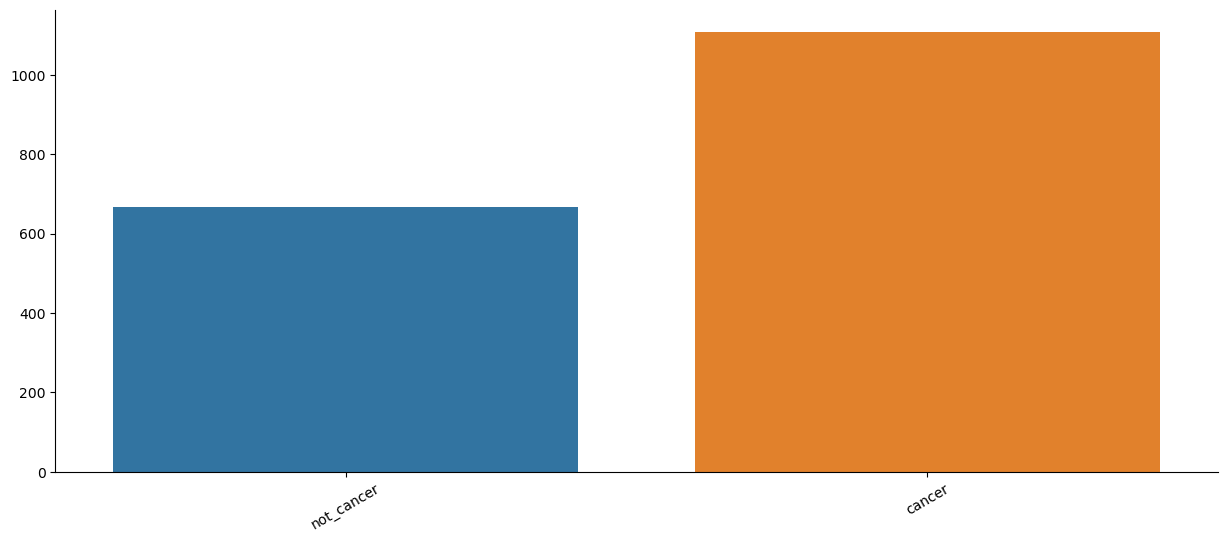

In [19]:
# ordered count of rows per unique label
labels_count = df['Labels'].value_counts(ascending=True)

f = plt.figure(figsize=(15, 6))
s = sns.barplot(labels_count.index,labels_count.values)
sns.despine()
s.set_xticklabels(s.get_xticklabels(), rotation = 30)

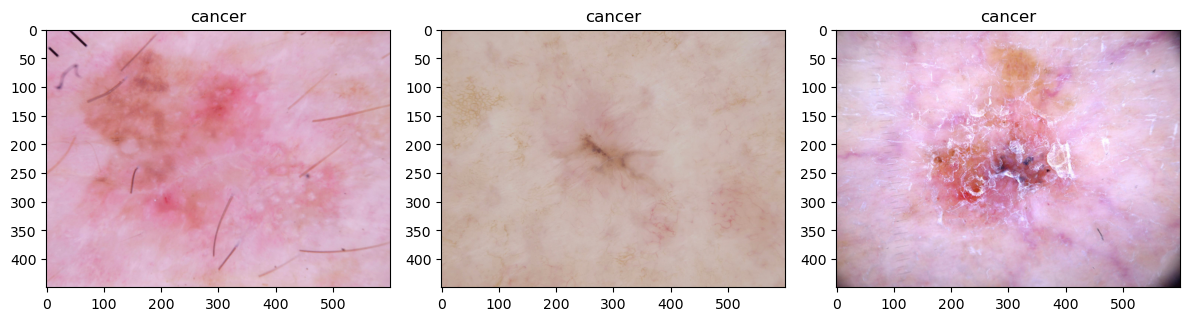

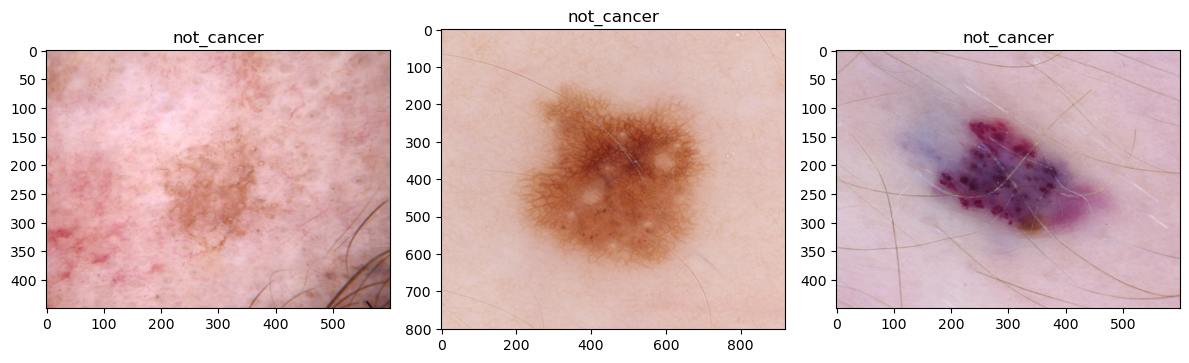

In [20]:
def plot_images_per_label(df, label, cols: int, size: tuple):
    fig, axs = plt.subplots(nrows=1, ncols=cols, figsize=size)

    cntMax = cols
    cntCur = 0
    for index, row in df.iterrows():
        if(row['Labels'] == label and cntCur < cntMax):
            axs[cntCur].imshow(plt.imread(df.FilePaths[index]))
            axs[cntCur].set_title(df.Labels[index])

            cntCur += 1
        else:
            if(cntCur >= cntMax):
                break
    
    plt.tight_layout()
    plt.show()


# unique labels
labels = sorted(df['Labels'].unique())
# loop through labels
for label in labels:
    plot_images_per_label(df, label, 3, (12,9))

In [21]:
# stratified train and val (20%) datasets
X_train, X_val = train_test_split(df, test_size=0.2, stratify=df['Labels'], random_state=1)

print('Train Data: ', X_train.shape)
print('Val Data: ', X_val.shape)

Train Data:  (1421, 2)
Val Data:  (356, 2)


In [22]:
# number of samples/images per iteration
BATCH_SIZE = 32
# input image size
IMG_SIZE = (224, 224)
# count of epchos
EPOCHS = 10

# image preprocessing
img_data_gen = ImageDataGenerator(shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input)

X_train = img_data_gen.flow_from_dataframe(dataframe=X_train,
                                           x_col='FilePaths',
                                           y_col='Labels',
                                           target_size=IMG_SIZE,
                                           color_mode='rgb',
                                           class_mode='categorical',
                                           batch_size=BATCH_SIZE,
                                           seed=1)

X_val = img_data_gen.flow_from_dataframe(dataframe=X_val,
                                         x_col='FilePaths',
                                         y_col='Labels',
                                         target_size=IMG_SIZE,
                                         color_mode='rgb',
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         seed=1)

Found 1421 validated image filenames belonging to 2 classes.
Found 356 validated image filenames belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
d:\Programy\Anaconda\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input dat

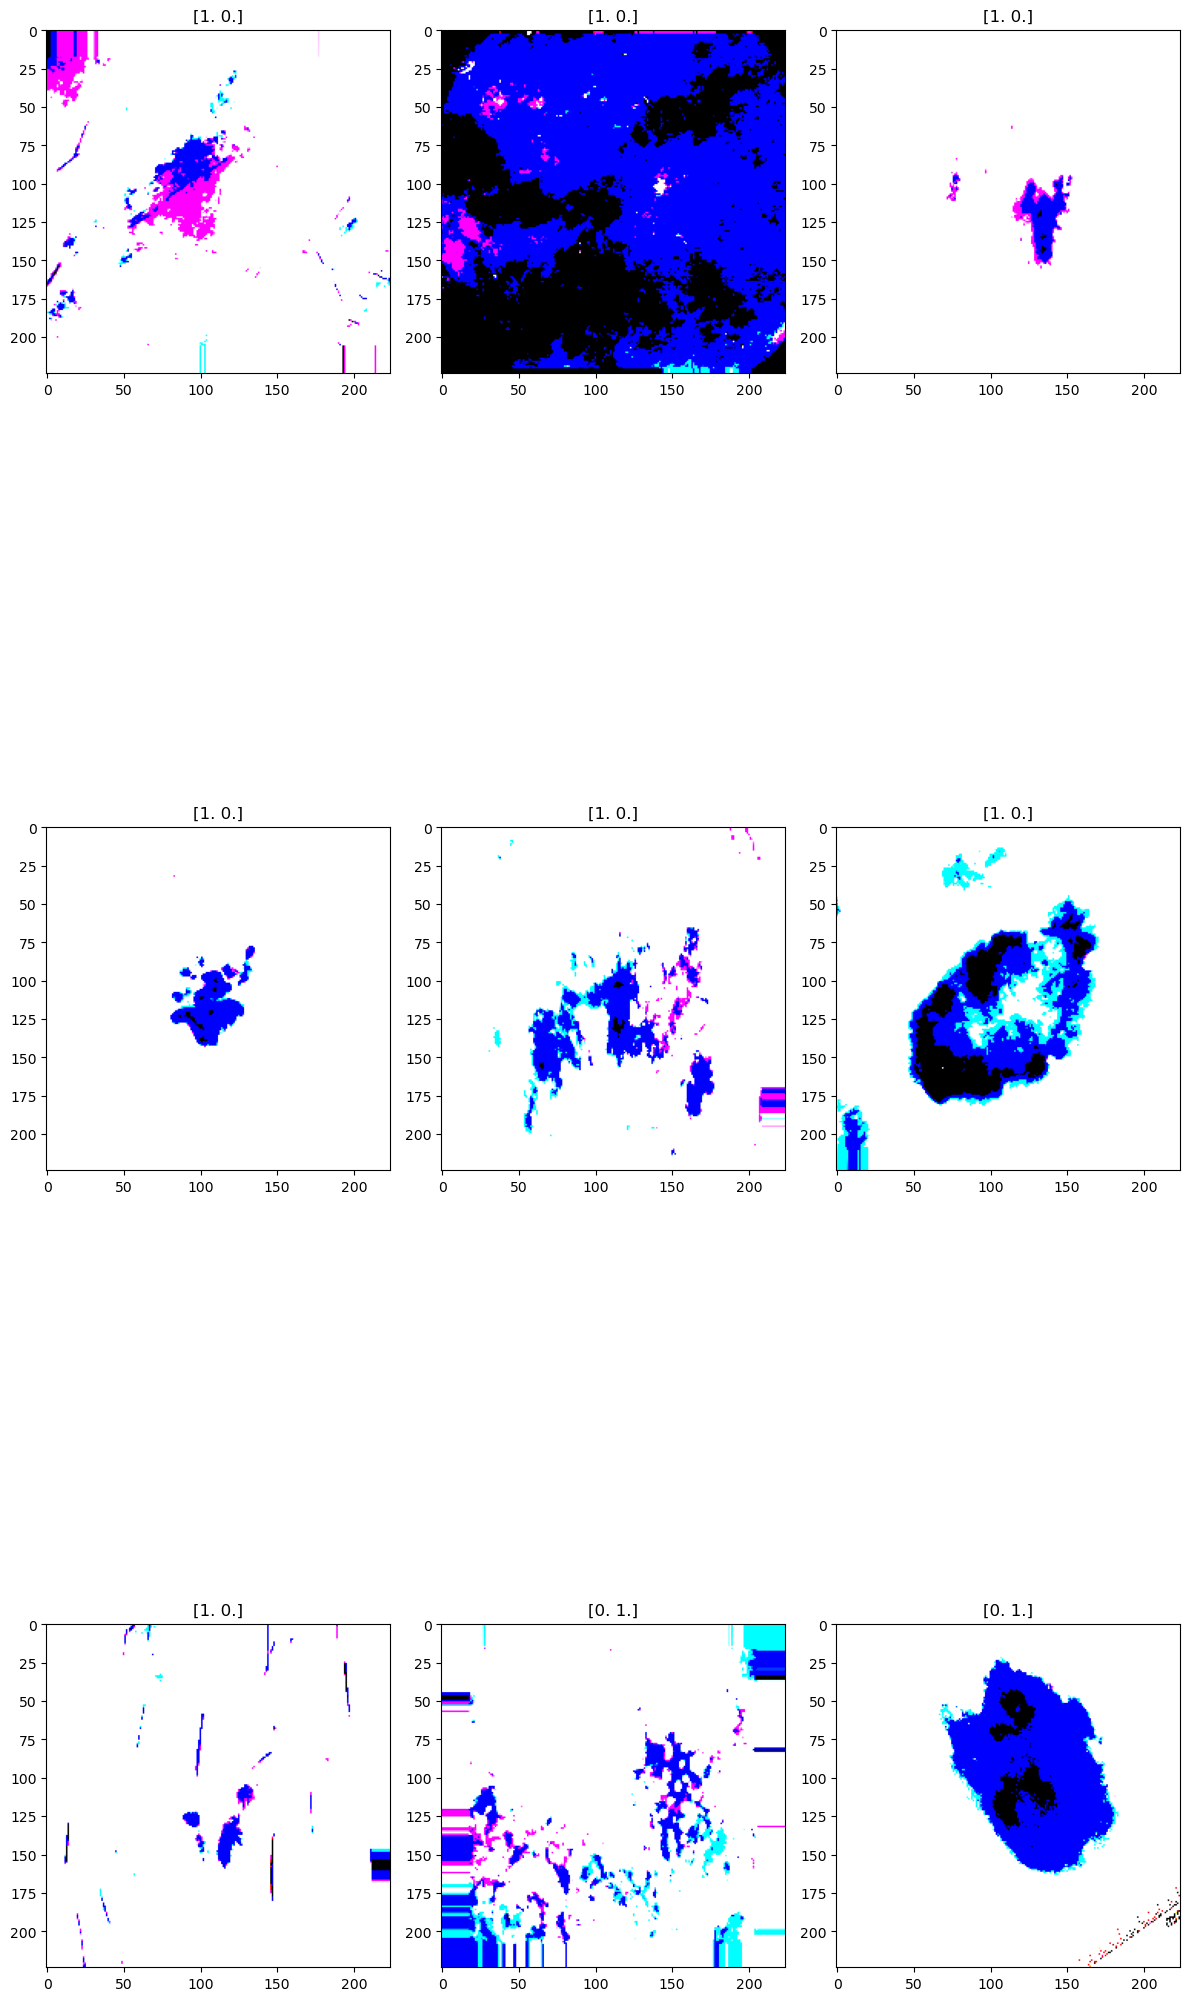

In [23]:
fit, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,27))

for i, a in enumerate(ax.flat):
    img, label = X_train.next()
    a.imshow(img[0],)
    a.set_title(label[0])

plt.tight_layout()
plt.show()

In [25]:
#training data
training_dir="data/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
#increases amount of data by making different forms of image
training_generator = ImageDataGenerator(rescale=1/255,
                                        featurewise_center = True,
                                        samplewise_center=True, 
                                        featurewise_std_normalization=False,
                                        samplewise_std_normalization=True,
                                        zca_whitening=False,
                                        rotation_range=30, 
                                        zoom_range=0.2, 
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=True, 
                                        vertical_flip=True)
#creates accessible training data
train_generator=training_generator.flow_from_directory(training_dir,target_size=(224,224), color_mode = "rgb",
                                                       batch_size=4,class_mode='binary')

Found 1777 images belonging to 2 classes.


In [26]:
#validation data
validation_dir="data/Skin cancer ISIC The International Skin Imaging Collaboration/Test"
#increases amount of data by making different forms of image
validation_generator=ImageDataGenerator(rescale=1/255)
val_generator=validation_generator.flow_from_directory(validation_dir,target_size=(224,224), color_mode="rgb", batch_size=4, class_mode='binary')

Found 102 images belonging to 2 classes.


In [27]:
#testing data
testing_dir="data/Skin cancer ISIC The International Skin Imaging Collaboration/Test"
#increases amount of data by making different forms of image
testing_generator = ImageDataGenerator(rescale=1/255,
                                        featurewise_center = False,
                                        samplewise_center=False, 
                                        featurewise_std_normalization=False,
                                        samplewise_std_normalization=False,
                                        zca_whitening=False,
                                        rotation_range=30, 
                                        zoom_range=0.2, 
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=False, 
                                        vertical_flip=False)
#creates accessible testing data
test_generator=training_generator.flow_from_directory(testing_dir,target_size=(224,224), 
                                                       batch_size=4,class_mode='binary')

Found 102 images belonging to 2 classes.


In [41]:
#model sequelling
model = Sequential()

model.add(layers.Conv2D(32, (3,3), input_shape = (224,224,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(256, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(1024, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

pokusy
1)
#přidáno
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))

2)
přidánay dvě další vrstvy
model.add(layers.Conv2D(512, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(1024, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))


In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 218, 218, 32)      4736      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 109, 109, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 107, 107, 64)      18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 53, 53, 64)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 53, 53, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 51, 51, 128)      

In [43]:
#compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

In [44]:
# stop training when accuracy has stopped improving 
# cb = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
# hst = model.fit(X_train, validation_data=X_val, epochs=EPOCHS, callbacks=cb)
# train model 
hst = model.fit(X_train, validation_data=X_val, epochs=EPOCHS)

Epoch 1/10
45/45 [==============================] - 137s 3s/step - loss: 3.9395 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 2/10
45/45 [==============================] - 139s 3s/step - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 3/10
45/45 [==============================] - 129s 3s/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 4/10
45/45 [==============================] - 115s 3s/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 5/10
45/45 [==============================] - 117s 3s/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 6/10
45/45 [==============================] - 115s 3s/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 7/10
45/45 [==============================] - 114s 3s/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 8/10
45/45 [==============================] - 114s 3s/step - loss: 0.6931 - a

In [ ]:
# model.save_weights('model',save_format='tf')

In [ ]:
# model.load_weights('model')

In [2]:
%matplotlib inline 
import matplotlib.pyplot as plt
acc = hst.history['acc']
val_acc = hst.history['val_acc']
loss = hst.history['loss']
val_loss = hst.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc= 0)
plt.figure()


NameError: name 'hst' is not defined

In [46]:
X_test = load_data('data/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [47]:
X_test.head()

,FilePaths,Labels
0,data\Skin cancer ISIC The International Skin I...,cancer
1,data\Skin cancer ISIC The International Skin I...,cancer
2,data\Skin cancer ISIC The International Skin I...,not_cancer
3,data\Skin cancer ISIC The International Skin I...,cancer
4,data\Skin cancer ISIC The International Skin I...,cancer


In [48]:
# image preprocessing
X_test = img_data_gen.flow_from_dataframe(dataframe=X_test,
                                          x_col='FilePaths',
                                          y_col='Labels',
                                          target_size=IMG_SIZE,
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=BATCH_SIZE,
                                          shuffle=False, # necessary fpr confusion matrix
                                          seed=1)

Found 102 validated image filenames belonging to 2 classes.


In [49]:
res = model.evaluate(X_test)

4/4 [==============================] - 7s 2s/step - loss: 0.6932 - acc: 0.5000


In [50]:
# accuracy
print(f'Train Accuracy: {hst.history["acc"][-1:][0] * 100:.2f}')
print(f'Val Accuracy: {hst.history["val_acc"][-1:][0] * 100:.2f}')
print(f'Test Accuracy: {res[1] * 100:.2f}')
# loss
print(f'Train Loss: {hst.history["loss"][-1:][0] * 100:.2f}')
print(f'Val Loss: {hst.history["val_loss"][-1:][0] * 100:.2f}')
print(f'Test Loss: {res[0] * 100:.2f}')

Train Accuracy: 50.00
Val Accuracy: 50.00
Test Accuracy: 50.00
Train Loss: 69.31
Val Loss: 69.31
Test Loss: 69.32


In [51]:
# predicted labels
Y_pred = model.predict(X_test)
print("Y_pred", Y_pred.shape)
# rounded labels
y_pred = np.argmax(Y_pred, axis=1)
print("y_pred", y_pred.size)

4/4 [==============================] - 7s 2s/step
Y_pred (102, 1)
y_pred 102


In [39]:
# true labels
y_true = X_test.classes
print("y_pred", len(y_pred))
# label classes
class_labels = list(X_test.class_indices.keys())
print("labels", len(class_labels))

y_pred 102
labels 2


In [1]:
# compare with true labels
cfm = confusion_matrix(y_pred, y_true, normalize='true')

# plot size
fig, ax = plt.subplots(figsize=(15,15))
# print confusion matrix
s = sns.heatmap(cfm,
               annot=True,
               cmap=['#ff0001', '#09AA11'],
               center=0.8,
               fmt='.1%',
               linewidths=.5,
               cbar_kws={'format': FuncFormatter(lambda x, pos: '{:.0%}'.format(x))}, #'label': 'Percentage' 
               linecolor='Black',
               ax=ax)
# set labels
s.set(xlabel='Predict', ylabel='True')
s.set(title='Confusion Matrix')
s.set_yticklabels([tw.fill(e, 10) for e in class_labels])
s.set_xticklabels([tw.fill(e, 10) for e in class_labels])

NameError: name 'confusion_matrix' is not defined